In [17]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from Big_Cats import Test_Cats, Train_Cats

In [18]:
def display_img(img,label):
    print(f"Label : {training_data.classes[label]}")
    plt.imshow(img.permute(1,2,0))
    
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

False


In [23]:
batch_size = 32
num_data = 1600
learning_rate = 0.05
big_cats_train = '../CNN_Big_Cats/Big_Cats/Train_Cats'
big_cats_test = '../CNN_Big_Cats/Big_Cats'

training_data = ImageFolder(big_cats_train, transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.RandomRotation(30), 
    transforms.ColorJitter(brightness=0.15, contrast=0.05, saturation=0.05, hue=0)]))

testing_data = ImageFolder(big_cats_test, transform = transforms.Compose([
    transforms.Resize((128, 128)), transforms.ToTensor()]))


train_size = len(training_data) - num_data



#For both datasets, each image is reszied to 150x150 pixels then converted to a tensor.
train_split, val_split = random_split(training_data, [train_size, num_data])


dload_train = DataLoader(train_split, batch_size, shuffle=True, num_workers = 4, pin_memory=True)
dload_test = DataLoader(val_split, batch_size*2, num_workers = 4, pin_memory=True)
n_total_steps = len(dload_train)



print(f"Training data length: {len(train_split)}")
print(f"Training data length: {len(val_split)}")



Training data length: 2000
Training data length: 1600


Image Size: torch.Size([3, 128, 128])
Which, means the image has 3 colour channels,and a length and width of 128 pixels. it has also been randomly
rotated and adjusted for brightness, hue, saturaton and potentially flipped as per our transformations.
Label : Test_Cats


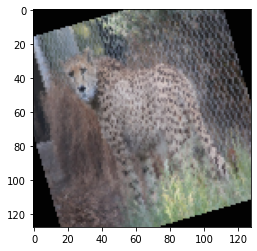

In [31]:
image, label = training_data[0]
print("Image Size: " + str(image.shape) + "\n" +"Which, means the image has 3 colour channels,\
and a length and width of 128 pixels. it has also been randomly" + "\n" +"rotated and adjusted \
for brightness, hue, saturaton and potentially flipped as per our transformations.")

display_img(image, label)



In [25]:
classes = ["hyena", 'cheetah']

print(len(classes))

2


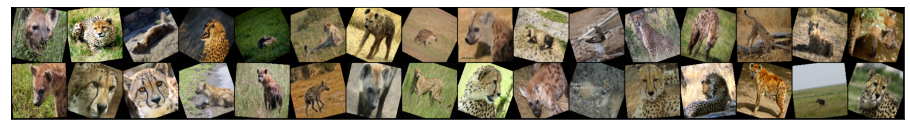

In [26]:
show_batch(dload_train)

In [8]:
# Here is where I shaped the network's layers through experimenting with
# gradually manipulating the image size through pooling and convolution.  

dataiter = iter(dload_train)
images, labels = dataiter.next()


conv1 = nn.Conv2d(3, 30, 5)
pool = nn.MaxPool2d(2, 2, padding=1)
conv2 = nn.Conv2d(30, 15, 5)

print(images.shape)

x = conv1(images)
print(x.shape)
x = pool(x)
print(x.shape)

x = conv2(x)
print(x.shape)

x = pool(x)
print(x.shape)



torch.Size([32, 3, 128, 128])
torch.Size([32, 30, 124, 124])
torch.Size([32, 30, 63, 63])
torch.Size([32, 15, 59, 59])
torch.Size([32, 15, 30, 30])


In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 30, 5)
        self.pool = nn.MaxPool2d(4, 4, padding=1)
        self.conv2 = nn.Conv2d(30, 15, 5)
        self.fc1 = nn.Linear(15*7*7, 100) #5*14*14 because our convolving filter and pooling decrease the img size.
        self.fc2 = nn.Linear(100, 2)
        self.dropout = nn.Dropout(0.5)

        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 15*7*7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x
    
model = CNN().to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_size = len(training_data) - num_data
num_epochs = 1200


In [11]:

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dload_train):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 7 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)
#loss 0.69 -> 0.001

Epoch [1/1200], Step [7/7], Loss: 0.6986
Epoch [2/1200], Step [7/7], Loss: 0.7082
Epoch [3/1200], Step [7/7], Loss: 0.6775
Epoch [4/1200], Step [7/7], Loss: 0.7077
Epoch [5/1200], Step [7/7], Loss: 0.6800
Epoch [6/1200], Step [7/7], Loss: 0.6938
Epoch [7/1200], Step [7/7], Loss: 0.6924
Epoch [8/1200], Step [7/7], Loss: 0.6896
Epoch [9/1200], Step [7/7], Loss: 0.7000
Epoch [10/1200], Step [7/7], Loss: 0.6646
Epoch [11/1200], Step [7/7], Loss: 0.7341
Epoch [12/1200], Step [7/7], Loss: 0.7020
Epoch [13/1200], Step [7/7], Loss: 0.6815
Epoch [14/1200], Step [7/7], Loss: 0.6966
Epoch [15/1200], Step [7/7], Loss: 0.7217
Epoch [16/1200], Step [7/7], Loss: 0.7099
Epoch [17/1200], Step [7/7], Loss: 0.6969
Epoch [18/1200], Step [7/7], Loss: 0.6495
Epoch [19/1200], Step [7/7], Loss: 0.7151
Epoch [20/1200], Step [7/7], Loss: 0.6696
Epoch [21/1200], Step [7/7], Loss: 0.6636
Epoch [22/1200], Step [7/7], Loss: 0.7468
Epoch [23/1200], Step [7/7], Loss: 0.6492
Epoch [24/1200], Step [7/7], Loss: 0.6860
E

Epoch [195/1200], Step [7/7], Loss: 0.3709
Epoch [196/1200], Step [7/7], Loss: 0.6397
Epoch [197/1200], Step [7/7], Loss: 0.5601
Epoch [198/1200], Step [7/7], Loss: 0.5168
Epoch [199/1200], Step [7/7], Loss: 0.4027
Epoch [200/1200], Step [7/7], Loss: 0.6042
Epoch [201/1200], Step [7/7], Loss: 0.3359
Epoch [202/1200], Step [7/7], Loss: 0.5763
Epoch [203/1200], Step [7/7], Loss: 0.5675
Epoch [204/1200], Step [7/7], Loss: 0.7345
Epoch [205/1200], Step [7/7], Loss: 0.7978
Epoch [206/1200], Step [7/7], Loss: 0.6196
Epoch [207/1200], Step [7/7], Loss: 0.6666
Epoch [208/1200], Step [7/7], Loss: 0.6874
Epoch [209/1200], Step [7/7], Loss: 0.3871
Epoch [210/1200], Step [7/7], Loss: 0.7386
Epoch [211/1200], Step [7/7], Loss: 0.4986
Epoch [212/1200], Step [7/7], Loss: 0.3035
Epoch [213/1200], Step [7/7], Loss: 0.4579
Epoch [214/1200], Step [7/7], Loss: 0.5082
Epoch [215/1200], Step [7/7], Loss: 0.5613
Epoch [216/1200], Step [7/7], Loss: 0.5466
Epoch [217/1200], Step [7/7], Loss: 0.9514
Epoch [218/

Epoch [386/1200], Step [7/7], Loss: 0.5471
Epoch [387/1200], Step [7/7], Loss: 0.4090
Epoch [388/1200], Step [7/7], Loss: 0.3150
Epoch [389/1200], Step [7/7], Loss: 1.3491
Epoch [390/1200], Step [7/7], Loss: 0.5518
Epoch [391/1200], Step [7/7], Loss: 0.4537
Epoch [392/1200], Step [7/7], Loss: 0.4366
Epoch [393/1200], Step [7/7], Loss: 0.3422
Epoch [394/1200], Step [7/7], Loss: 0.4551
Epoch [395/1200], Step [7/7], Loss: 0.3356
Epoch [396/1200], Step [7/7], Loss: 0.4253
Epoch [397/1200], Step [7/7], Loss: 0.3401
Epoch [398/1200], Step [7/7], Loss: 0.4108
Epoch [399/1200], Step [7/7], Loss: 0.6606
Epoch [400/1200], Step [7/7], Loss: 0.3196
Epoch [401/1200], Step [7/7], Loss: 0.5765
Epoch [402/1200], Step [7/7], Loss: 0.6190
Epoch [403/1200], Step [7/7], Loss: 0.2923
Epoch [404/1200], Step [7/7], Loss: 0.5391
Epoch [405/1200], Step [7/7], Loss: 0.1772
Epoch [406/1200], Step [7/7], Loss: 0.3362
Epoch [407/1200], Step [7/7], Loss: 0.5515
Epoch [408/1200], Step [7/7], Loss: 0.5106
Epoch [409/

Epoch [577/1200], Step [7/7], Loss: 0.3624
Epoch [578/1200], Step [7/7], Loss: 0.0782
Epoch [579/1200], Step [7/7], Loss: 0.0974
Epoch [580/1200], Step [7/7], Loss: 0.0734
Epoch [581/1200], Step [7/7], Loss: 0.0729
Epoch [582/1200], Step [7/7], Loss: 0.0171
Epoch [583/1200], Step [7/7], Loss: 0.0398
Epoch [584/1200], Step [7/7], Loss: 0.0262
Epoch [585/1200], Step [7/7], Loss: 0.0542
Epoch [586/1200], Step [7/7], Loss: 0.0766
Epoch [587/1200], Step [7/7], Loss: 0.0240
Epoch [588/1200], Step [7/7], Loss: 0.0538
Epoch [589/1200], Step [7/7], Loss: 0.0659
Epoch [590/1200], Step [7/7], Loss: 0.1157
Epoch [591/1200], Step [7/7], Loss: 0.1737
Epoch [592/1200], Step [7/7], Loss: 0.0422
Epoch [593/1200], Step [7/7], Loss: 0.0815
Epoch [594/1200], Step [7/7], Loss: 0.1100
Epoch [595/1200], Step [7/7], Loss: 0.0654
Epoch [596/1200], Step [7/7], Loss: 0.2451
Epoch [597/1200], Step [7/7], Loss: 0.3479
Epoch [598/1200], Step [7/7], Loss: 0.0504
Epoch [599/1200], Step [7/7], Loss: 0.1663
Epoch [600/

Epoch [768/1200], Step [7/7], Loss: 0.0522
Epoch [769/1200], Step [7/7], Loss: 0.0697
Epoch [770/1200], Step [7/7], Loss: 0.1148
Epoch [771/1200], Step [7/7], Loss: 0.1753
Epoch [772/1200], Step [7/7], Loss: 0.1726
Epoch [773/1200], Step [7/7], Loss: 0.0615
Epoch [774/1200], Step [7/7], Loss: 0.1084
Epoch [775/1200], Step [7/7], Loss: 0.0046
Epoch [776/1200], Step [7/7], Loss: 0.0226
Epoch [777/1200], Step [7/7], Loss: 0.0810
Epoch [778/1200], Step [7/7], Loss: 0.0134
Epoch [779/1200], Step [7/7], Loss: 0.3793
Epoch [780/1200], Step [7/7], Loss: 0.0036
Epoch [781/1200], Step [7/7], Loss: 0.0769
Epoch [782/1200], Step [7/7], Loss: 0.0030
Epoch [783/1200], Step [7/7], Loss: 0.0505
Epoch [784/1200], Step [7/7], Loss: 0.0134
Epoch [785/1200], Step [7/7], Loss: 0.2010
Epoch [786/1200], Step [7/7], Loss: 0.1669
Epoch [787/1200], Step [7/7], Loss: 0.0038
Epoch [788/1200], Step [7/7], Loss: 0.1170
Epoch [789/1200], Step [7/7], Loss: 0.0011
Epoch [790/1200], Step [7/7], Loss: 0.1357
Epoch [791/

Epoch [959/1200], Step [7/7], Loss: 0.5479
Epoch [960/1200], Step [7/7], Loss: 0.2953
Epoch [961/1200], Step [7/7], Loss: 0.0060
Epoch [962/1200], Step [7/7], Loss: 0.0049
Epoch [963/1200], Step [7/7], Loss: 0.0043
Epoch [964/1200], Step [7/7], Loss: 0.0005
Epoch [965/1200], Step [7/7], Loss: 0.0474
Epoch [966/1200], Step [7/7], Loss: 0.2053
Epoch [967/1200], Step [7/7], Loss: 0.0606
Epoch [968/1200], Step [7/7], Loss: 0.0166
Epoch [969/1200], Step [7/7], Loss: 0.0065
Epoch [970/1200], Step [7/7], Loss: 0.0760
Epoch [971/1200], Step [7/7], Loss: 0.2871
Epoch [972/1200], Step [7/7], Loss: 0.0259
Epoch [973/1200], Step [7/7], Loss: 0.0287
Epoch [974/1200], Step [7/7], Loss: 0.0318
Epoch [975/1200], Step [7/7], Loss: 0.0020
Epoch [976/1200], Step [7/7], Loss: 0.0805
Epoch [977/1200], Step [7/7], Loss: 0.0111
Epoch [978/1200], Step [7/7], Loss: 0.0016
Epoch [979/1200], Step [7/7], Loss: 0.0473
Epoch [980/1200], Step [7/7], Loss: 0.0023
Epoch [981/1200], Step [7/7], Loss: 0.0016
Epoch [982/

Epoch [1147/1200], Step [7/7], Loss: 0.0035
Epoch [1148/1200], Step [7/7], Loss: 0.4155
Epoch [1149/1200], Step [7/7], Loss: 0.0361
Epoch [1150/1200], Step [7/7], Loss: 0.0084
Epoch [1151/1200], Step [7/7], Loss: 0.0008
Epoch [1152/1200], Step [7/7], Loss: 0.0160
Epoch [1153/1200], Step [7/7], Loss: 0.0003
Epoch [1154/1200], Step [7/7], Loss: 0.2042
Epoch [1155/1200], Step [7/7], Loss: 0.1289
Epoch [1156/1200], Step [7/7], Loss: 0.0004
Epoch [1157/1200], Step [7/7], Loss: 0.0000
Epoch [1158/1200], Step [7/7], Loss: 0.0105
Epoch [1159/1200], Step [7/7], Loss: 0.0009
Epoch [1160/1200], Step [7/7], Loss: 0.0092
Epoch [1161/1200], Step [7/7], Loss: 0.0426
Epoch [1162/1200], Step [7/7], Loss: 0.0256
Epoch [1163/1200], Step [7/7], Loss: 0.0511
Epoch [1164/1200], Step [7/7], Loss: 0.0192
Epoch [1165/1200], Step [7/7], Loss: 0.0030
Epoch [1166/1200], Step [7/7], Loss: 0.5122
Epoch [1167/1200], Step [7/7], Loss: 0.0121
Epoch [1168/1200], Step [7/7], Loss: 0.0197
Epoch [1169/1200], Step [7/7], L

In [15]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples

In [16]:
print(f"Accuracy on training set: {check_accuracy(dload_train, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(dload_test, model)*100:.2f}")

Accuracy on training set: 100.00
Accuracy on test set: 92.12
